This notebook demonstrates using conservation laws in Kwant 1.3.

Thanks goes to Tómas Rosdahl for his work on this algorithm.

Assuming you have Kwant build environment set up, you'll need to execute the following to get everything required to run the notebook:
```bash
pip3 install git+https://gitlab.kwant-project.org/kwant/tinyarray.git@master
pip3 install git+https://gitlab.kwant-project.org/kwant/kwant.git@master
```

In [13]:
%matplotlib inline
import kwant
import tinyarray as ta
import numpy as np
from scipy import sparse
from matplotlib import pyplot
import matplotlib

In [14]:
s0 = ta.array([[1, 0], [0, 1]])
sx = ta.array([[0, 1], [1, 0]])
sy = ta.array([[0, 1j], [-1j, 0]])
sz = ta.array([[1, 0], [0, -1]])

In [15]:
# Adapted from https://kwant-project.org/doc/1/tutorial/tutorial2

def make_system(t=1.0, W=10, L=10):
    # Now we must specify the number of orbitals per site.
    lat = kwant.lattice.square(norbs=2)
    syst = kwant.Builder()

    syst[(lat(x, y) for x in range(L) for y in range(W))] = \
            lambda s, alpha, E_z: 4 * t * s0 + E_z * sz
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = \
            lambda s1, s2, alpha, E_z: -t * s0 - 1j * alpha * sy
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = \
            lambda s1, s2, alpha, E_z: -t * s0 + 1j * alpha * sx

    # The new bit: specifying the conservation law.
    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)),
                         conservation_law=-sz, time_reversal=s0)
    lead[(lat(0, j) for j in range(W))] = 4 * t * s0
    lead[lat.neighbors()] = -t * s0 # Note: no spin-orbit in the lead.

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    syst = syst.finalized()


    return syst

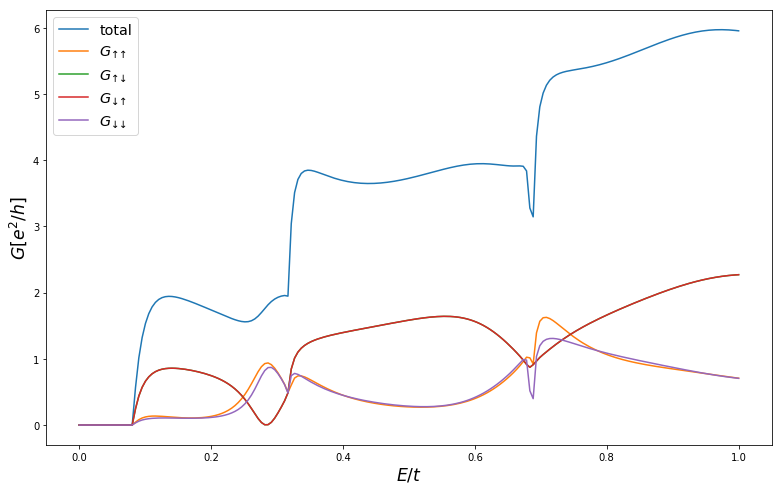

In [16]:
syst = make_system(t=1.0, W=10, L=10)
energies = np.linspace(0, 1, 200)
smatrices = [kwant.smatrix(syst, energy, args=(0.2, 0.05)) for energy in energies]

fig = pyplot.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1)

# Like previously smatrix.transmission(lead1, lead0) is transmission from lead0 to lead1
ax.plot(energies, [smatrix.transmission(1, 0) for smatrix in smatrices], label='total')

# The new bit: smatrix.transmission((lead1, q1), (lead0, q0)) is the transmission from the
# q0 block of the lead0 into the q1 block of lead1. The subblock ordering is same as we used
# in set_symmetry.
ax.plot(energies, [smatrix.transmission((1, 0), (0, 0)) for smatrix in smatrices], label='$G_{↑↑}$')
ax.plot(energies, [smatrix.transmission((1, 1), (0, 0)) for smatrix in smatrices], label='$G_{↑↓}$')
ax.plot(energies, [smatrix.transmission((1, 0), (0, 1)) for smatrix in smatrices], label='$G_{↓↑}$')
ax.plot(energies, [smatrix.transmission((1, 1), (0, 1)) for smatrix in smatrices], label='$G_{↓↓}$')
ax.set_ylabel('$G [e^2/h]$', fontsize='xx-large')
ax.set_xlabel('$E/t$', fontsize='xx-large')
ax.legend(fontsize='x-large');

In [39]:
s = kwant.smatrix(syst, energy=1, args=(0.2, 0))
print("r_↑↑ = r_↓↓^T")
print(np.round(s.submatrix((0, 1), (0, 1)) - s.submatrix((0, 0), (0, 0)).T, 6))
print("r_↑↓ = -r_↑↓^T")
print(np.round(s.submatrix((0, 1), (0, 0)) + s.submatrix((0, 1), (0, 0)).T, 6))

r_↑↑ = r_↓↓^T
[[ 0.+0.j -0.-0.j  0.+0.j]
 [-0.-0.j  0.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]]
r_↑↓ = -r_↑↓^T
[[ 0.+0.j -0.-0.j  0.+0.j]
 [-0.-0.j  0.+0.j -0.-0.j]
 [ 0.+0.j -0.-0.j  0.-0.j]]


In [40]:
modes = s.lead_info[0]

# Wave functions in different spin blocks coincide.
modes.wave_functions[:, [0, 3]]

array([[-0.09250579-0.00437932j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.09250579-0.00437932j],
       [-0.17751732-0.00840386j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.17751732-0.00840386j],
       [-0.24814745-0.01174756j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.24814745-0.01174756j],
       [-0.29867414-0.01413955j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.29867414-0.01413955j],
       [-0.32500404-0.01538604j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.32500404-0.01538604j],
       [-0.32500404-0.01538604j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.32500404-0.01538604j],
       [-0.29867414-0.01413955j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.29867414-0.01413955j],
       [-0.24814745-0.01174756j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        , -0.24814745-0.01174756j],
       [-0.17751732-0.00840386j,  0.00000000+0.j        